In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np

import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder, Generate
import pandas as pd

from scprint.utils.utils import volcano
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
import bionty as bt
import ot

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [ ]:
# ! uv pip install POT

In [2]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/"  # "./normalize_log/"

# another one (human mouse)


In [ ]:
len(set(human.var.index) & set(mouse.var.index.str.upper()))

13090

In [ ]:
human = sc.read(LOC + "task4_human.h5ad")
mouse = sc.read(LOC + "task4_mouse.h5ad")

In [4]:
def revert_to_raw(adata):
    res = adata.X
    res = np.exp(res) - 1
    res = (
        (res.T / np.array([res[i][res[i] != 0].min() for i in range(res.shape[0])]))
        .round()
        .T
    )  # .sum()
    adata.X = res
    return adata

In [6]:
human.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
mouse.obs["organism_ontology_term_id"] = "NCBITaxon:10090"

In [7]:
mouse = revert_to_raw(mouse)
human = revert_to_raw(human)

In [5]:
mouse.var.index = mouse.var.index.str.upper()
human = human[:, human.var.index.isin(mouse.var.index)]
mouse = mouse[:, mouse.var.index.isin(human.var.index)]

In [ ]:
human.X = scipy.sparse.csr_matrix(human.X)
mouse.X = scipy.sparse.csr_matrix(mouse.X)

In [ ]:
preprocessor = Preprocessor(
    is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False
)
human = preprocessor(human.copy())
mouse = preprocessor(mouse.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 52816 renamining
filtered out 5 cells, 52811 renamining
Removed 4285 genes not known to the ontology
Removed 0 duplicate genes
Added 53430 genes in the ontology but not present in the dataset
starting QC
Seeing 5700 outliers (10.79% of total dataset):
done
AnnData object with n_obs × n_vars = 52811 × 70116
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism

In [9]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
    "Proximal tubule cellAscending loop of Henle": "CL:1000909",
    "Intercalated cells of collecting duct": "CL:0005010",
    "Erythroid cell": "CL:0000764",
    "Microglia": "CL:0000129",
    "Distal convoluted tubule": "CL:1000849",
    "Connecting tubule cell": "CL:1000768",
}

res = (
    bt.CellType.standardize(
        mouse.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Macrophage': 'CL:0000235',
 'Astrocyte': 'CL:0000127',
 'Oligodendrocyte': 'CL:0000128',
 'Epithelial cell': 'CL:0000066',
 'Dendritic cell': 'CL:0000451',
 'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Neutrophil': 'CL:0000775',
 'Hepatocyte': 'CL:0000182',
 'Plasma cell': 'CL:0000786',
 'Cardiomyocyte': 'CL:0000746',
 'Neural progenitor cell': 'CL:0011020',
 'Erythroblast': 'CL:0000765',
 'Mast cell': 'CL:0000097',
 'Ependymal cell': 'CL:0000065',
 'Mesenchymal cell': 'CL:0008019',
 'Basal cell': 'CL:0000646',
 'Myocyte': 'CL:0000187',
 'Enterocyte': 'CL:0000584',
 'Unknown': 'unknown',
 'Megakaryocyte': 'CL:0000556',
 'Chondrocyte': 'CL:0000138',
 'Goblet cell': 'CL:0000160',
 'Striated muscle cell': 'CL:0000737',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': '

In [10]:
mouse.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in mouse.obs["celltype"].values
]

In [11]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
}

res = (
    bt.CellType.standardize(
        human.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Epithelial cell': 'CL:0000066',
 'Intercalated cell': 'CL:0005010',
 'Macrophage': 'CL:0000235',
 'Dendritic cell': 'CL:0000451',
 'Stromal cell': 'CL:0000499',
 'Neutrophil': 'CL:0000775',
 'Mast cell': 'CL:0000097',
 'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Ureteric bud cell': 'CL:4030066',
 'Goblet cell': 'CL:0000160',
 'Myeloid cell': 'CL:0000763',
 'Stratified epithelial cell': 'CL:0000079',
 'Basal cell': 'CL:0000646',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': 'CL:0000499',
 'Epithelial cell (intermediated)': 'CL:0000066'}

In [ ]:
human.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in human.obs["celltype"].values
]

In [ ]:
human.write(LOC + "proc_hum.h5ad")
mouse.write(LOC + "proc_mouse.h5ad")

... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


In [3]:
human = sc.read(LOC + "proc_hum.h5ad")
mouse = sc.read(LOC + "proc_mouse.h5ad")

## re-generate those cell types with mouse genes and compare


In [4]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/ji9krimq.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [5]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [ ]:
embed = Embedder(
    how="random expr",
    max_len=2600,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
    save_every=20_000,
)
n_adata, _ = embed(model, human)

[autoreload of scprint.tasks failed: Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/pasteur/appa/homes/jkalfon/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/__init__.py", line 7, in <module>
    from .impute import Imputerqq
ImportError: cannot import name

not on wandb, could not set name


 38%|███▊      | 312/826 [03:07<04:54,  1.75it/s]

logging
logging the anndata
AnnData object with n_obs × n_vars = 20032 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 's

In [ ]:
n_adata.write_h5ad(LOC + "emb_hum.h5ad")

In [19]:
n_adata = sc.read_h5ad(LOC + "emb_hum.h5ad")

In [ ]:
mouse = mouse[mouse.obs["orig.ident"] != "mouse_Brain"]

In [ ]:
embed = Embedder(
    how="random expr",
    max_len=2600,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)
sup, _ = embed(model, mouse)  # np.random.choice(mouse.shape[0], 1000, replace=False)])

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


logging the anndata
AnnData object with n_obs × n_vars = 2000 × 21550
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_th

In [ ]:
sup.write_h5ad(LOC + "emb_mouse.h5ad")

In [33]:
sup = sc.read_h5ad(LOC + "emb_mouse.h5ad")

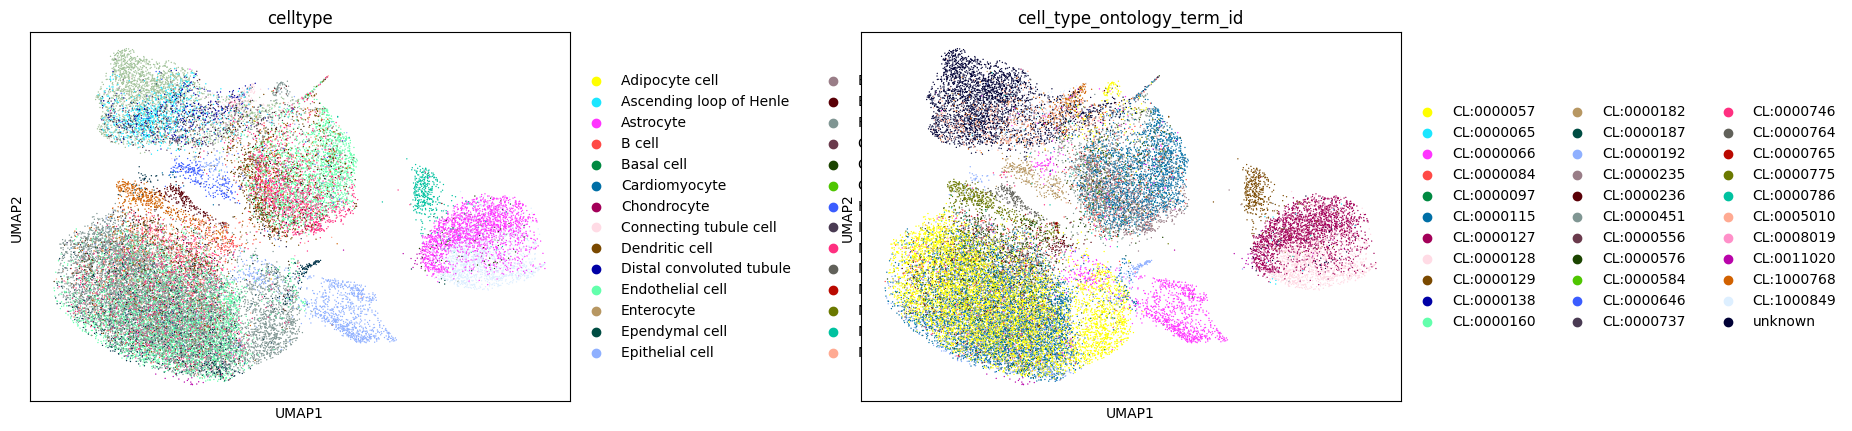

In [15]:
sc.pp.neighbors(sup, use_rep="scprint_emb_organism_ontology_term_id")
sc.tl.umap(sup)
sc.pl.umap(sup, color=["celltype", "cell_type_ontology_term_id"], wspace=0.4)

In [ ]:
sup.obsm["scprint_emb_organism_ontology_term_id"] = np.tile(
    n_adata.obsm["scprint_emb_organism_ontology_term_id"].mean(0), (sup.shape[0], 1)
)

In [ ]:
human = human[
    :,
    human.var.symbol.isin(mouse.var.symbol.str.upper())
    & human.var.index.isin(model.genes),
]

In [ ]:
sc.pp.highly_variable_genes(human, n_top_genes=5000, flavor="seurat_v3")

In [ ]:
rand = np.random.choice(
    min(human.X.shape[0], mouse.X.shape[0]), size=10_000, replace=False
)

In [ ]:
human = human[rand, human.var["highly_variable"]]
mouse = mouse[
    rand,
    mouse.var.symbol.str.upper().isin(
        human.var.symbol[human.var["highly_variable"]].tolist()
    )
    & mouse.var.index.isin(model.genes),
]
mouse = mouse[:, ~mouse.var.symbol.duplicated(keep="first")]
human = human[:, human.var.symbol.isin(mouse.var.symbol.str.upper())]
mouse = mouse[:, mouse.var.symbol.str.upper().argsort()]
human = human[:, human.var.symbol.argsort()]

In [ ]:
genes = human.var.index.tolist()
len(genes)

4990

In [ ]:
# if it doesn't work, try with a much smaller dataset

In [ ]:
elems = [
    "scprint_emb_age_group",
    "scprint_emb_assay_ontology_term_id",
    "scprint_emb_cell_culture",
    "scprint_emb_cell_type_ontology_term_id",
    "scprint_emb_disease_ontology_term_id",
    "scprint_emb_organism_ontology_term_id",
    "scprint_emb_other",
    "scprint_emb_self_reported_ethnicity_ontology_term_id",
    "scprint_emb_sex_ontology_term_id",
    "scprint_emb_tissue_ontology_term_id",
]

In [ ]:
generator = Generate(genelist=genes, batch_size=32)

In [ ]:
pred = generator(model, sup)

not on wandb, could not set name


100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


In [ ]:
pred.write_h5ad(LOC + "pred_as_human.h5ad")

In [32]:
pred = sc.read_h5ad(LOC + "pred_as_human.h5ad")

In [63]:
human.X.sum(1).mean(), mouse.X.sum(1).mean(), pred.X.sum(1).mean()

(np.float32(250.9618), np.float32(237.9519), np.float32(864.9844))

In [ ]:
res = ot.solve_sample(
    torch.Tensor(pred.X).to(device="cuda"),
    torch.Tensor(mouse.X.todense()).to(device="cuda"),
    reg=0.1,
)
res.value

tensor(14915.7344, device='cuda:0')

In [62]:
res = ot.solve_sample(
    torch.Tensor(human.X.todense()).to(device="cuda"),
    torch.Tensor(mouse.X.todense()).to(device="cuda"),
    reg=0.1,
)
res.value

tensor(2593.2876, device='cuda:0')

In [ ]:
pred.var = human.var.copy()
mouse.var = human.var.copy()

In [ ]:
toc = ad.concat([pred, mouse], label="organism", merge="same")
toc.obs = toc.obs.replace({"organism": {"0": "as_human", "1": "mouse"}})
toc.var.set_index("symbol", inplace=True)

/local/scratch/tmp/ipykernel_3938377/3687006840.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  toc.obs = toc.obs.replace({"organism": {"0": "as_human", "1": "mouse"}})


In [ ]:
# full diff expr
sc.pp.normalize_total(toc, target_sum=1e4)
sc.pp.log1p(toc)

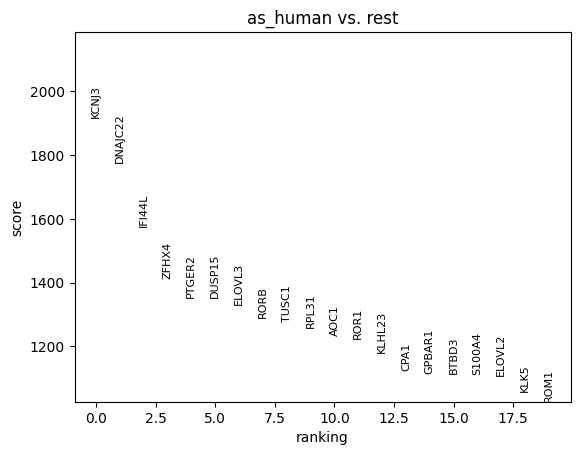

In [ ]:
sc.tl.rank_genes_groups(
    toc, groupby="organism", method="t-test_overestim_var", groups=["as_human"]
)
sc.pl.rank_genes_groups(toc)

In [ ]:
# Create a dictionary or pandas Series with genes and their scores
gene_names = [i[0] for i in toc.uns["rank_genes_groups"]["names"]]
gene_scores = [i[0] for i in toc.uns["rank_genes_groups"]["scores"]]
rnk_pred = pd.Series(gene_scores, index=gene_names)

KeyError: 'rank_genes_groups'

In [ ]:
rnk_pred[:10]

In [ ]:
enr = gp.prerank(
    rnk=rnk,
    gene_sets=[
        "Reactome_2022"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=mouse.var.index.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.0].head(20)

### human mouse

In [77]:
toc = ad.concat([human, mouse], label="organism", merge="same")
toc.obs = toc.obs.replace({"organism": {"0": "human", "1": "mouse"}})
toc.var.set_index("symbol", inplace=True)

/local/scratch/tmp/ipykernel_3938377/1061945737.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  toc.obs = toc.obs.replace({"organism": {"0": "human", "1": "mouse"}})


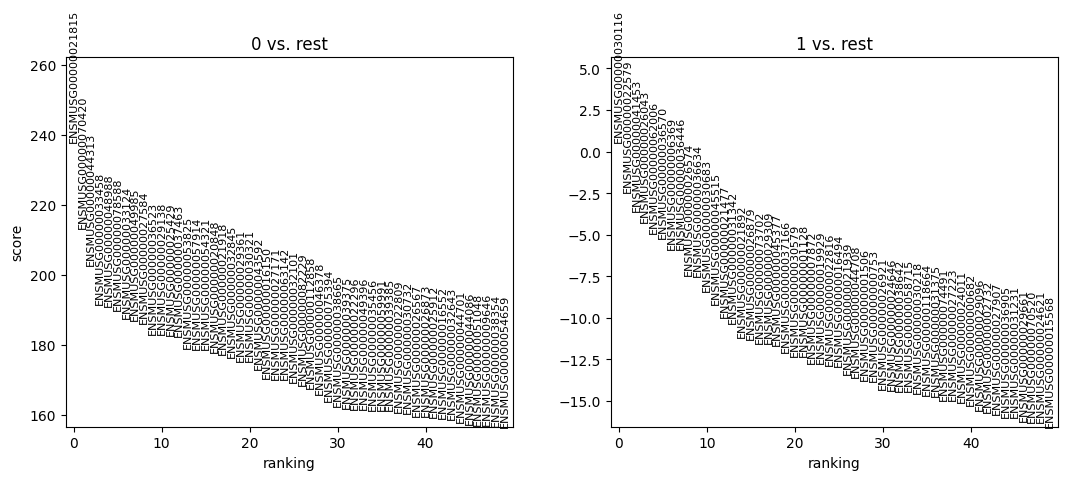

In [ ]:
# full diff expr
sc.pp.normalize_total(toc, target_sum=1e4)
sc.pp.log1p(toc)

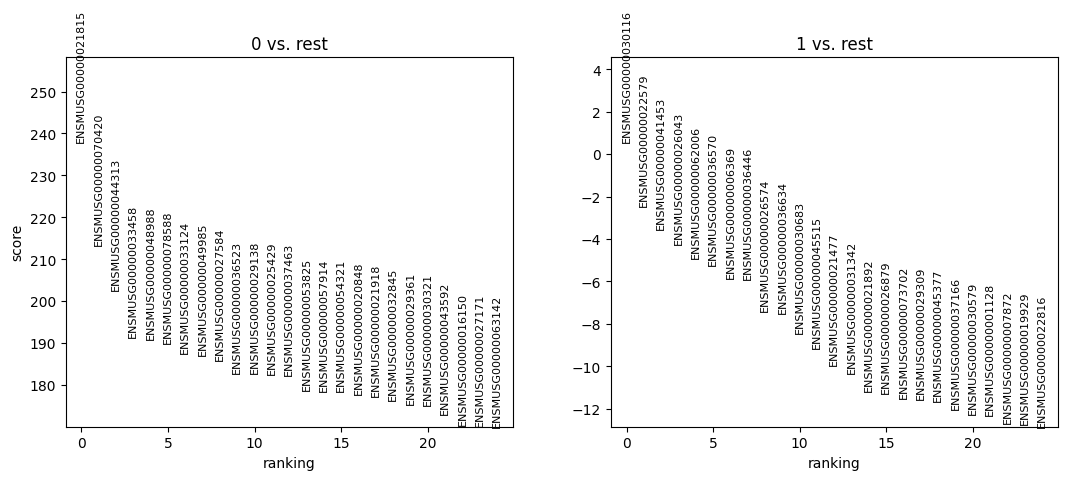

In [ ]:
sc.tl.rank_genes_groups(
    toc, groupby="organism", method="t-test_overestim_var", groups=["human"]
)
sc.pl.rank_genes_groups(toc)  # ,

In [78]:
# Create a dictionary or pandas Series with genes and their scores
gene_names = [i[0] for i in toc.uns["rank_genes_groups"]["names"]]
gene_scores = [i[0] for i in toc.uns["rank_genes_groups"]["scores"]]
rnk = pd.Series(gene_scores, index=gene_names)

KeyError: 'rank_genes_groups'

In [ ]:
rnk[::-1][:10]

In [ ]:
enr = gp.prerank(
    rnk=rnk,
    gene_sets=[
        "Reactome_2022"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=mouse.var.index.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.0].head(20)

## the two of them

In [ ]:
TOP = 50
len(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) / TOP

In [ ]:
# mouse turned as human vs mouse
Reactome_2022_Cellular Response To Starvation...
Reactome_2022 Protein Localization R-HSA-960950
Blood Thymus
bone marrow, b cell, t cell, macrophave, myeloid progenitor
Human_Striated muscle
contraction
myopathi
cardiomyopathy

# mouse vs human
Reactome_2022__Collagen
ECM, proteoglycans
UBIquitin, RNA pol
DNA TF binding, cell cell adhesion some nuclear, glucocorticoid receptor

In [ ]:
import matplotlib.pyplot as plt

# Test different TOP values
top_values = range(5, 5001, 5)
overlaps = []
random_overlaps = []

total_genes = len(rnk)

for TOP in top_values:
    # Calculate actual overlap
    actual_overlap = (
        len(set(rnk[::-1][:TOP].index) & set(rnk_pred[::-1][:TOP].index)) / TOP
    )
    overlaps.append(actual_overlap)

    # Calculate expected overlap by random chance
    # P(overlap) = TOP / total genes for each gene
    random_overlap = TOP / total_genes
    random_overlaps.append(random_overlap)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(top_values, overlaps, label="Actual Overlap", linewidth=2, color="blue")
plt.plot(
    top_values,
    random_overlaps,
    label="Random Chance",
    linewidth=2,
    linestyle="--",
    color="red",
)
# Add text to the plot
plt.text(
    0.95,
    0.05,
    f"Mean actual overlap: {np.mean (overlaps):.4f}\n"
    f"Mean random overlap: {np.mean (random_overlaps):.4f}\n"
    f"Fold enrichment: {np.mean (overlaps) / np.mean (random_overlaps):.2f}x",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.xlabel("TOP (Number of genes)", fontsize=12)
plt.ylabel("Overlap Fraction", fontsize=12)
plt.title("Gene Overlap: Actual vs Random Chance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Test different TOP values
top_values = range(5, 5001, 5)
overlaps = []
random_overlaps = []

total_genes = len(rnk)

for TOP in top_values:
    # Calculate actual overlap
    actual_overlap = len(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) / TOP
    overlaps.append(actual_overlap)

    # Calculate expected overlap by random chance
    # P(overlap) = TOP / total genes for each gene
    random_overlap = TOP / total_genes
    random_overlaps.append(random_overlap)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(top_values, overlaps, label="Actual Overlap", linewidth=2, color="blue")
plt.plot(
    top_values,
    random_overlaps,
    label="Random Chance",
    linewidth=2,
    linestyle="--",
    color="red",
)
# Add text to the plot
plt.text(
    0.95,
    0.05,
    f"Mean actual overlap: {np.mean (overlaps):.4f}\n"
    f"Mean random overlap: {np.mean (random_overlaps):.4f}\n"
    f"Fold enrichment: {np.mean (overlaps) / np.mean (random_overlaps):.2f}x",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.xlabel("TOP (Number of genes)", fontsize=12)
plt.ylabel("Overlap Fraction", fontsize=12)
plt.title("Gene Overlap: Actual vs Random Chance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
names = [i[0] for i in toc.uns["rank_genes_groups"]["names"]]
p_vals = [i[0] for i in toc.uns["rank_genes_groups"]["pvals_adj"]]
gene_scores = [i[0] for i in toc.uns["rank_genes_groups"]["logfoldchanges"]]
genes_to_high = list(set(rnk[:TOP].index) & set(rnk_pred[:TOP].index)) + list(
    set(rnk[::-1][:TOP].index) & set(rnk_pred[::-1][:TOP].index)
)

In [ ]:
volcda = pd.DataFrame(
    {"log2FoldChange": gene_scores, "pvalue": p_vals, "gene_id": gene_names},
    index=list(range(len(gene_names))),
)

In [ ]:
volcano(volcda, tohighlight=genes_to_high, showlabels=True)

## now generate them in female


In [ ]:
# diff expr analysis

## now in cancer


In [ ]:
# diff expr analysis